# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models

from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import json

In [2]:
def check_gpu():
    '''
        :None
        This function only serves to help the user understand if their machine is capable of running on the gpu
    '''

    # Check if GPU/CUDA capability is even possible with the downloaded version of torch

    # Verify that the GPU is available
    print("Torch version:",torch.__version__)
    print("Is CUDA enabled?",torch.cuda.is_available())

    return None

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [3]:
def transform_normalize_load_batch(data_path, batch_size=64):
    '''
        :data_path - the path of the flowers data for this project
        :batch_size - the requested batch_size for the training, default is 64

        This function will transform, normalize, load, and batch
        
        :return - 3 dataloaders (train, valid, and test)
    '''

    # These paths are unique to how the data is stored!
    data_dir = data_path
    train_dir = data_dir + '/train'
    valid_dir = data_dir + '/valid'
    test_dir = data_dir + '/test'

    data_transforms_train = transforms.Compose([transforms.RandomRotation(30),
                                                transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406],
                                                                     [0.229, 0.224, 0.225])])

    data_transforms_valid = transforms.Compose([transforms.Resize(255),
                                                transforms.CenterCrop(224),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406],
                                                                     [0.229, 0.224, 0.225])])

    data_transforms_test = transforms.Compose([transforms.Resize(255),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406],
                                                                    [0.229, 0.224, 0.225])])

    image_datasets_train = datasets.ImageFolder(train_dir, transform=data_transforms_train)
    image_datasets_valid = datasets.ImageFolder(valid_dir, transform=data_transforms_valid)
    image_datasets_test  = datasets.ImageFolder(test_dir,  transform=data_transforms_test)

    dataloaders_train = torch.utils.data.DataLoader(image_datasets_train, batch_size=batch_size, shuffle=True)
    dataloaders_valid = torch.utils.data.DataLoader(image_datasets_valid, batch_size=batch_size)
    dataloaders_test  = torch.utils.data.DataLoader(image_datasets_test,  batch_size=batch_size)

    return (dataloaders_train, dataloaders_valid, dataloaders_test, image_datasets_train)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
def label_mapping():
    '''
        :No inputs

        This function was provided to us.
        It simply reads a json file and returns the contents of that json file

        :return - cat_to_name (json file)
    '''

    with open('cat_to_name.json', 'r') as f:
        cat_to_name = json.load(f)

    return cat_to_name

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

### VGG16 (138.4M params)

In [5]:
# Set up the original VGG16 Model
# Use the default weights for everything at first
weightsvgg16 = models.VGG16_Weights.DEFAULT
vgg16 = models.vgg16(weights=weightsvgg16)

# Freeze Parameters so we don't backprop through them
for param in vgg16.parameters():
    param.requires_grad = False

# Remember that each of these names in the OrderedDict CANNOT be the same as any other name... so name them uniquely!
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 2500)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(0.2)),
    ('fc2', nn.Linear(2500, 1024)),
    ('relu2', nn.ReLU()),
    ('dropout2', nn.Dropout(0.2)),
    ('fc3', nn.Linear(1024,256)),
    ('relu3', nn.ReLU()),
    ('dropout3', nn.Dropout(0.2)),
    ('fc4', nn.Linear(256,102)),
    ('output1', nn.LogSoftmax(dim=1))
]))

vgg16.classifier = classifier
vgg16.name = 'vgg16'

optimizervgg16 = optim.Adam(vgg16.classifier.parameters(), lr=0.001)

### ResNet50 (25.6M Params)

In [6]:
# # Set up the original Resnet50 Model
# # Use the default weights for everything at first
# weightsrn50 = models.ResNet50_Weights.DEFAULT
# resnet50 = models.resnet50(weights=weightsrn50)

# # Freeze Parameters so we don't backprop through them
# for param in resnet50.parameters():
#     param.requires_grad = False

# fc = nn.Sequential(OrderedDict([
#     ('fc1', nn.Linear(2048, 500)),
#     ('relu1', nn.ReLU()),
#     ('dropout1', nn.Dropout(0.2)),
#     ('fc2', nn.Linear(500, 255)),
#     ('relu2', nn.ReLU()),
#     ('dropout2', nn.Dropout(0.2)),
#     ('fc3', nn.Linear(255,102)),
#     ('output1', nn.LogSoftmax(dim=1))
# ]))

# resnet50.fc = fc
# resnet50.name = 'resnet50'

# optimizerresnet50 = optim.SGD(resnet50.fc.parameters(), lr=0.001)

In [7]:
# Optimizer & criterion
optimizer = optimizervgg16
criterion = nn.NLLLoss()

In [ ]:
# NOTE: ONLY RUN THIS CELL IF YOU WANT TO RETRAIN THE NETWORK!!!!!!!!!!!

path = "models/test.pth"
model = vgg16
dataloaders_train = transform_normalize_load_batch('assets/flowers_MFV')[0]
dataloaders_valid = transform_normalize_load_batch('assets/flowers_MFV')[1]
epochs = 10
print_every = 10

# Move the model over to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Some initalizations required for training/validating
best_valid_loss = float('inf')
steps = 0
running_loss_train = 0

# Let's also add some lists so that we can track losses and accuracies
train_losses = []
valid_losses = []
valid_accuracy = []

# An epoch is defined as a single run through of the entire (training) set of data
# 6552 images/labels
for epoch in range(epochs):

    # Put the model into training
    model.train()

    # dataloaders_train contains 103 'passes' which accounts for ALL images/labels
    for images_train, labels_train in dataloaders_train:

        # Increment the steps for nice readouts
        steps += 1

        # Move things over to the GPU!
        images_train =  images_train.to(device)
        labels_train =  labels_train.to(device)

        # The classic pattern
        optimizer.zero_grad()
        logps = model(images_train)
        loss = criterion(logps, labels_train)
        loss.backward()
        optimizer.step()
        running_loss_train += loss.item()

        if steps % print_every == 0:

            # Put the model into eval mode
            model.eval()

            with torch.no_grad():

                running_loss_valid = 0
                accuracy_valid = 0

                # dataloaders_valid contains 818 images
                # so for a batch size of 64 we get 13 'passes' which accounts for ALL images/labels
                for images_valid, labels_valid in dataloaders_valid:

                    # Move things over the GPU!
                    images_valid = images_valid.to(device)
                    labels_valid = labels_valid.to(device)

                    logps      = model(images_valid)
                    valid_loss = criterion(logps, labels_valid)
                    running_loss_valid += valid_loss.item()

                    # Calculate Accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equal = top_class == labels_valid.view(*top_class.shape)
                    accuracy_valid += torch.mean(equal.type(torch.FloatTensor)).item()

            rlt = running_loss_train/print_every
            rlv = running_loss_valid/len(dataloaders_valid)
            acc = accuracy_valid/len(dataloaders_valid)
            
            print(f"Epoch {epoch+1}/{epochs}.. "
                    f"Train loss: {rlt:.3f}.. "
                    f"Valid loss: {rlv:.3f}.. "
                    f"Valid accuracy: {acc:.3f}")
            
            train_losses.append(rlt)
            valid_losses.append(rlv)
            valid_accuracy.append(acc)
            
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss

                torch.save(model.state_dict(), path)
            
            # Reinitialize the running_loss to be 0 for the new epoch
            running_loss_train = 0

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [8]:

state_dict = torch.load('models/VGG16_BestModel_072823.pth')
model = vgg16
model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)
criterion = nn.NLLLoss()

dataloaders_test = transform_normalize_load_batch('assets/flowers_MFV')[2]

with torch.no_grad():
    running_test_loss = 0
    test_accuracy = 0
    for images_test, labels_test in dataloaders_test:

        # Move things over the GPU!
        images_test = images_test.to(device)
        labels_test = labels_test.to(device)

        logps = model(images_test)
        test_loss = criterion(logps, labels_test)
        running_test_loss += test_loss.item()

        # Calculate Accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equal = top_class == labels_test.view(*top_class.shape)
        test_accuracy += torch.mean(equal.type(torch.FloatTensor)).item()

print(f"Test accuracy: {test_accuracy/len(dataloaders_test):.3f}")

Test accuracy: 0.832


## Save the checkpoint

Now that your network is trained, save the mo|del so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [ ]:

image_datasets_train = transform_normalize_load_batch('assets/flowers_MFV')[3]
model.class_to_idx = image_datasets_train.class_to_idx

checkpoint = {'model': models.vgg16(),
                  'state_dict': model.state_dict(),
                  'optimizer': optimizer,
                  'optimizer_state': optimizer.state_dict(),
                  'Num_Epochs': epochs,
                  'train_losses_list': train_losses,
                  'valid_losses_list': valid_losses,
                  'valid_accuracy_list': valid_accuracy,
                  'valid_loss': best_valid_loss,
                  'class_to_idx': model.class_to_idx
                  }

torch.save(checkpoint, 'checkpoints/test.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [9]:
def load_checkpoint(filepath_, model_name, optimizer_name):
    checkpoint = torch.load(filepath_)

    model_name.load_state_dict(checkpoint['state_dict']) # Return the model!
    optimizer_name.load_state_dict(checkpoint['optimizer_state']) # Return the optimizer!
    num_epoch = checkpoint['Num_Epochs']
    train_losses = checkpoint['train_losses_list']
    valid_losses = checkpoint['valid_losses_list'],
    valid_accuracy_list = checkpoint['valid_accuracy_list']
    best_valid_loss = checkpoint['valid_loss']
    class_to_idx = checkpoint['class_to_idx']
    
    return model, optimizer, num_epoch, train_losses, valid_losses, valid_accuracy_list, best_valid_loss, class_to_idx

In [10]:
model_vgg16, optimizer_vgg16, num_epoch, \
    train_losses_loaded, valid_losses_loaded, \
        valid_accuracy_loaded, best_valid_loss_loaded, class_to_idx = load_checkpoint('checkpoints/VGG16_Checkpoint_072823.pth', vgg16, optimizer)

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [11]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # Open the image using the 'Image' toolkit and get the original dimensions
    _256 = int(256)
    _224 = int(224)
    ogWidth, ogHeight = image.size
    ar = ogWidth/ogHeight

    # Determine which is longer
    if ogWidth < ogHeight:
        newWidth = _256
        newHeight = int(_256/ar)
    else:
        newHeight = _256
        newWidth = int(_256*ar)
    
    # This resizes the image where the shortest side is 256 and the aspect ratio is maintained
    imResize = image.resize((newWidth, newHeight))

    # This crops the newly resized image so that it is 224x224
    # This performs a center crop
    left   = int((newWidth - _224) / 2)
    top    = int((newHeight - _224) / 2)
    right  = int((newWidth + _224) / 2)
    bottom = int((newHeight + _224) / 2)
    imCrop = imResize.crop((left, top, right, bottom))

    # Now we maniuplate the image
    imNp = np.array(imCrop)
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    # Transform the np.array via the mean and the standard deviation
    imNp = imNp / 255
    imNp = imNp - mean
    imNp = imNp / std

    # Reorder so that PyTorch is happy
    imNp = imNp.transpose((2,0,1))

    return imNp

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [12]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    # A CORRECTION WAS MADE: removed .numpy() after image as the output from "process_image" already returns a numpy.ndarray
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.axis('off')
    ax.imshow(image)
    
    return ax

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [13]:
def predict(image_path, model, class_to_idx, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # Open the image via the path and process the image per our previous function
    image = Image.open(image_path)
    image = process_image(image)

    # imTen = torch.from_numpy(image)
    imTen = torch.tensor(image).float()

    # Need to add "1" to the beginning to dummy the batch size
    # unsqueeze_ is the only method I could find that does exactly that
    imTen = imTen.unsqueeze(0)

    # Move items to device
    im = imTen.to(device)
    model.to(device)

    # Make sure that the model is in eval mode
    model.eval()

    # Now we run through our model for the single image we have

    with torch.no_grad():

        # Move the model forward as we normally would
        # But this time convert the log prob to normal prob
        logps = model(im)
        prob = torch.exp(logps)

        # Utilize topk method
        probs, indices = torch.topk(prob, topk)

        # Need to move classes to the cpu in order for numpy to work
        indice = indices.to('cpu')
        indice = indice.numpy()[0]

        # Same can be said about the probabilities
        probs = probs.to('cpu')
        probs = probs.numpy()[0].tolist()

        # Use dictionary comprehension to make value, key pairs
        idx_to_class = {val: key for key, val in class_to_idx.items()}

        # Spit out the correct class labels
        classes = [idx_to_class[index] for index in indice]
        

    return probs, classes

In [14]:
predict("assets/flowers_MFV/test/1/image_06743.jpg", model_vgg16, class_to_idx)

([0.9916760921478271,
  0.0044326637871563435,
  0.0030951490625739098,
  0.0002184546465286985,
  0.00020349650003481656],
 ['1', '83', '97', '91', '51'])

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [15]:
def final_output(image_path, model, class_to_idx):

    '''
        :image_path - this is the path of the image you want to check
            It is exactly the same path that we tested 'predict' on
        :model - this is the model that you want to use
            It is a model that we saved from before using a checkpoint
    '''

    # Getting the picture of the image that you are investigating
    image = Image.open(image_path)

    probs, classes = predict(image_path, model, class_to_idx)

    cat_to_name = label_mapping()

    # matplotlib plays nicer with numpy arrays
    probs = np.array(probs)
    classes = np.array(classes)

    # Now we have the names of the flowers and not just their assigned numbers...
    names = [cat_to_name[num] for num in classes]

    # Now we just need to graph everything!
    plt.figure(figsize=(3,4))

    ax1 = plt.subplot(2,1,1)
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(names[0])

    ax2 = plt.subplot(2,1,2)
    ax2.barh(names, probs)

    ax2.invert_yaxis()
    ax2.set_xlabel('Probability')


    return {"Name of Predicted Flower": names[0],
            "Probability of Prediction": round(probs[0]*100, 2)}

    

{'Name of Predicted Flower': 'pink primrose',
 'Probability of Prediction': 99.17}

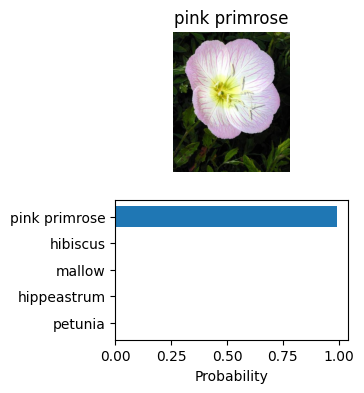

In [16]:
final_output("assets/flowers_MFV/test/1/image_06743.jpg", model_vgg16, class_to_idx)